In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
from pathlib import Path
import numpy as np
import torch
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import re
import torch.utils.data as data
from dataclasses import dataclass
import pandas as pd

from fuzzywuzzy import process
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import math
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter


from avae.model import AttentionVae, GPTConfig
from avae.dataset import CharDataset
from avae.trainer import TrainerConfig, Trainer
from avae.utils import pad_word, depad_word, encode_word, decode_word
from avae.utils import generate_samples
writer = SummaryWriter('runs/avae')

This notebook is used to load the model and trains it on some data.

Point the model to a local corpus dataset.

For example download wiki-text2 here:
https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip

In [3]:
PROJECT_DIR  = Path(".").resolve().parent.parent
DATA_DIR  = PROJECT_DIR / "data"
WIKI_DIR  = DATA_DIR / "wikitext-2"
NAMES_DIR  = DATA_DIR / "names"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def clean_word(word):
    word = word.replace("\n", '').lower()
    return word

# Sample Generation

In [61]:
def print_generation(model, unique_train_words=None, context=""):

    print(f"Context: {context}")
    samples = generate_samples(model, n_samples=20, initial_context=context)
    samples = list(set(samples))
    for sample in samples:

        if unique_train_words:
            match = process.extract(sample, unique_train_words, limit=1)[0][0]
            sample += f"\t\t closest match: {match}"
        print(sample)
    print()


def generation_testing(model, unique_train_words=None):
    print_generation(model, unique_train_words=unique_train_words)
    print_generation(model, context="a", unique_train_words=unique_train_words)
    print_generation(model, context="m", unique_train_words=unique_train_words)
    print_generation(model, context="sim", unique_train_words=unique_train_words)

In [62]:
generation_testing(frozen_wiki_vae, train_dataset.unique_word_list)

Context: 
wendy		 closest match: wendy
zenone		 closest match: zenone
nicolette		 closest match: nicolette
nelle		 closest match: noelle
zdene		 closest match: denez
zachire		 closest match: zacharie
angeline		 closest match: angeline
nathana		 closest match: nathan
zenobe		 closest match: zenobe
loelle		 closest match: lo
theodulph		 closest match: theodulphe

Context: a
aigna		 closest match: aignan
aubert		 closest match: aubert
annelle		 closest match: annaelle
alde		 closest match: waldemar
angeline		 closest match: angeline
alis		 closest match: alis
afrede		 closest match: alfrede

Context: m
melise		 closest match: melisse
melvine		 closest match: melvine
mallouine		 closest match: lo
mathel		 closest match: mathe
mathie		 closest match: mathie

Context: sim
simplice		 closest match: simplice
sime		 closest match: simeon
simonde		 closest match: simone
simpline		 closest match: line



# Load french names

In [35]:
french_names = []
with open(NAMES_DIR / "french_names_no_accent.txt", "r") as f:
    for word in f:
        french_names.append(clean_word(word))
wiki_vae = AttentionVae.load("wiki_model")

split = 0.9
idx = int(len(french_names) * split)
np.random.seed(137)
np.random.shuffle(french_names)
train_french_names = french_names[:idx]
val_french_names = french_names[idx:]

raw_train_french_names = " ".join(train_french_names)
raw_val_french_names = " ".join(val_french_names)

wiki_vae = AttentionVae.load("wiki_model")
chars = list(wiki_vae.stoi.keys())
maxlen = wiki_vae.config.block_size

train_dataset = CharDataset(raw_train_french_names, maxlen, chars=chars)
val_dataset = CharDataset(raw_val_french_names, maxlen, chars=chars)

idx=298
x, y, word = train_dataset[idx]
print("x: ",decode_word(x.numpy(), wiki_vae.itos))
print("y: ",decode_word(y.numpy(), wiki_vae.itos))
print("word :", decode_word(word.numpy(), wiki_vae.itos))

tconf = TrainerConfig(
    max_epochs=30,
    batch_size=256,
    learning_rate=6e-4,
    lr_decay=True,
    warmup_tokens=128 * 20,
    final_tokens=2 * len(train_dataset) * maxlen,
    num_workers=4,
    sample_freq=10000
)
trainer = Trainer(wiki_vae, train_dataset, val_dataset, tconf,log_nearest_words=True)
losses = trainer.train()


data has 34421 characters, 47 unique.
data has 3750 characters, 47 unique.
x:  genest
y:  genest
word : genest


epoch 1) iter 0: train_loss 221.1972198, lr = 5.999922e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: lovestite                 	 closes match: lo 
Sample: nerter                    	 closes match: nerea 
Sample: keat                      	 closes match: katy 
Sample: inflictive                	 closes match: felicie 


epoch 1) iter 2: train_loss 221.8724060, lr = 5.998594e-04:   2%|▏         | 3/135 [00:02<04:10,  1.89s/it]

Sample: altens                    	 closes match: valens 


epoch 1) iter 134: train_loss 217.7487335, lr = 3.006754e-04: 100%|██████████| 135/135 [00:13<00:00,  9.79it/s]


Test loss: 218.34076029459635


epoch 2) iter 0: train_loss 218.9137115, lr = 2.971632e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: ment                      	 closes match: clement 
Sample: ennee                     	 closes match: andrienne 
Sample: zeo                       	 closes match: zeno 
Sample: ydane                     	 closes match: lydiane 


epoch 2) iter 2: train_loss 218.6653137, lr = 2.901402e-04:   2%|▏         | 3/135 [00:03<04:28,  2.04s/it]

Sample: estaliciand               	 closes match: ali 


epoch 2) iter 134: train_loss 217.7823944, lr = 6.000000e-05: 100%|██████████| 135/135 [00:14<00:00,  9.57it/s]


Test loss: 218.06612650553384


epoch 3) iter 0: train_loss 218.3840332, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: maelien                   	 closes match: maelie 
Sample: zene                      	 closes match: zeline 
Sample: zender                    	 closes match: zenaide 
Sample: ghone                     	 closes match: philogone 


epoch 3) iter 2: train_loss 218.4553375, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:27,  1.57s/it]

Sample: nellino                   	 closes match: lin 


epoch 3) iter 134: train_loss 218.1147461, lr = 3.006754e-04: 100%|██████████| 135/135 [00:13<00:00, 10.07it/s]


Test loss: 218.1951924641927


epoch 4) iter 0: train_loss 218.0912781, lr = 3.041876e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: leothia                   	 closes match: leo 
Sample: zena                      	 closes match: zenaide 
Sample: zeerenda                  	 closes match: edern 
Sample: siana                     	 closes match: siana 


epoch 4) iter 2: train_loss 218.2676392, lr = 3.112098e-04:   2%|▏         | 3/135 [00:02<03:39,  1.66s/it]

Sample: zevian                    	 closes match: ian 


epoch 4) iter 134: train_loss 218.4042206, lr = 5.999970e-04: 100%|██████████| 135/135 [00:13<00:00, 10.01it/s]


Test loss: 218.23566182454428


epoch 5) iter 0: train_loss 218.0426941, lr = 5.999606e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: sthain                    	 closes match: stan 
Sample: loridos                   	 closes match: lo 
Sample: genes                     	 closes match: genes 
Sample: malada                    	 closes match: ada 


epoch 5) iter 2: train_loss 218.2601318, lr = 5.997645e-04:   2%|▏         | 3/135 [00:02<03:17,  1.50s/it]

Sample: zelene                    	 closes match: zeline 


epoch 5) iter 134: train_loss 218.7323761, lr = 2.979737e-04: 100%|██████████| 135/135 [00:13<00:00, 10.16it/s]


Test loss: 217.9995340983073


epoch 6) iter 0: train_loss 217.6628418, lr = 2.944616e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zenatel                   	 closes match: enael 
Sample: stepho                    	 closes match: sephora 
Sample: zepither                  	 closes match: thery 
Sample: sherin                    	 closes match: sherine 


epoch 6) iter 2: train_loss 218.1204071, lr = 2.874403e-04:   2%|▏         | 3/135 [00:02<03:17,  1.50s/it]

Sample: zeven                     	 closes match: even 


epoch 6) iter 134: train_loss 218.1537018, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00, 10.16it/s]


Test loss: 217.90409342447916


epoch 7) iter 0: train_loss 217.8555603, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: matifa                    	 closes match: if 
Sample: zderyle                   	 closes match: erle 
Sample: gweras                    	 closes match: gervais 
Sample: themith                   	 closes match: remi 


epoch 7) iter 2: train_loss 217.6666565, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:06,  1.41s/it]

Sample: yvany                     	 closes match: yvanne 


epoch 7) iter 134: train_loss 217.9501495, lr = 3.033772e-04: 100%|██████████| 135/135 [00:13<00:00, 10.26it/s]


Test loss: 218.00618693033854


epoch 8) iter 0: train_loss 218.1159973, lr = 3.068890e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: naud                      	 closes match: naud 
Sample: mathie                    	 closes match: mathie 
Sample: auden                     	 closes match: audren 
Sample: aglael                    	 closes match: aglae 


epoch 8) iter 2: train_loss 217.7930908, lr = 3.139092e-04:   2%|▏         | 3/135 [00:02<03:33,  1.62s/it]

Sample: zaphan                    	 closes match: hans 


epoch 8) iter 134: train_loss 218.0961761, lr = 5.999726e-04: 100%|██████████| 135/135 [00:13<00:00, 10.03it/s]


Test loss: 218.04776611328126


epoch 9) iter 0: train_loss 218.3325043, lr = 5.999046e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: xentilis                  	 closes match: lis 
Sample: medgund                   	 closes match: ed 
Sample: gweneven                  	 closes match: gwen 
Sample: nadoline                  	 closes match: line 


epoch 9) iter 2: train_loss 217.4822998, lr = 5.996453e-04:   2%|▏         | 3/135 [00:02<03:24,  1.55s/it]

Sample: zenest                    	 closes match: genest 


epoch 9) iter 134: train_loss 218.4389954, lr = 2.952721e-04: 100%|██████████| 135/135 [00:13<00:00, 10.07it/s]


Test loss: 218.01382344563802


epoch 10) iter 0: train_loss 217.6452026, lr = 2.917606e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: rena                      	 closes match: renaldine 
Sample: zepty                     	 closes match: zephyr 
Sample: yan                       	 closes match: maryanna 
Sample: aliann                    	 closes match: ann 


epoch 10) iter 2: train_loss 217.6456451, lr = 2.847415e-04:   2%|▏         | 3/135 [00:02<03:52,  1.76s/it]

Sample: ybny                      	 closes match: benny 


epoch 10) iter 134: train_loss 216.7731476, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00,  9.84it/s]


Test loss: 217.74701029459635


epoch 11) iter 0: train_loss 217.8895569, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zeane                     	 closes match: zerane 
Sample: leon                      	 closes match: leon 
Sample: nathuriane                	 closes match: ian 
Sample: neoular                   	 closes match: neo 


epoch 11) iter 2: train_loss 217.3485718, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<04:14,  1.93s/it]

Sample: steliopha                 	 closes match: telio 


epoch 11) iter 134: train_loss 217.3155365, lr = 3.060786e-04: 100%|██████████| 135/135 [00:13<00:00,  9.68it/s]


Test loss: 217.85577189127605


epoch 12) iter 0: train_loss 217.4737244, lr = 3.095897e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: melise                    	 closes match: melisse 
Sample: melise                    	 closes match: melisse 
Sample: kellen                    	 closes match: ellen 
Sample: mary                      	 closes match: maryse 


epoch 12) iter 2: train_loss 217.6512146, lr = 3.166075e-04:   2%|▏         | 3/135 [00:02<03:32,  1.61s/it]

Sample: stellomo                  	 closes match: lo 


epoch 12) iter 134: train_loss 218.2095795, lr = 5.999240e-04: 100%|██████████| 135/135 [00:13<00:00,  9.98it/s]


Test loss: 217.95561625162762


epoch 13) iter 0: train_loss 217.8765259, lr = 5.998243e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zenaethe                  	 closes match: ethel 
Sample: yse                       	 closes match: maryse 
Sample: neilbon                   	 closes match: neil 
Sample: zea                       	 closes match: elzear 


epoch 13) iter 2: train_loss 218.3569946, lr = 5.995018e-04:   2%|▏         | 3/135 [00:02<03:40,  1.67s/it]

Sample: kariand                   	 closes match: ian 


epoch 13) iter 134: train_loss 217.5040436, lr = 2.925708e-04: 100%|██████████| 135/135 [00:13<00:00,  9.96it/s]


Test loss: 217.83471171061197


epoch 14) iter 0: train_loss 217.7664185, lr = 2.890602e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: neore                     	 closes match: neo 
Sample: naime                     	 closes match: aime 
Sample: maluottais                	 closes match: malu 
Sample: aniaba                    	 closes match: ania 


epoch 14) iter 2: train_loss 217.4203491, lr = 2.820438e-04:   2%|▏         | 3/135 [00:02<03:47,  1.72s/it]

Sample: matieg                    	 closes match: mati 


epoch 14) iter 134: train_loss 217.4300385, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00,  9.92it/s]


Test loss: 217.7251210530599


epoch 15) iter 0: train_loss 217.3674316, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: naritine                  	 closes match: toine 
Sample: malisse                   	 closes match: ali 
Sample: elophanne                 	 closes match: ann 
Sample: geonnaet                  	 closes match: bonne 


epoch 15) iter 2: train_loss 217.5428467, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:56,  1.79s/it]

Sample: enno                      	 closes match: bennon 


epoch 15) iter 134: train_loss 216.8354492, lr = 3.087796e-04: 100%|██████████| 135/135 [00:13<00:00,  9.83it/s]


Test loss: 217.76002705891926


epoch 16) iter 0: train_loss 217.3640747, lr = 3.122897e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: nede                      	 closes match: ed 
Sample: nerina                    	 closes match: nina 
Sample: natille                   	 closes match: castille 
Sample: neside                    	 closes match: nessie 


epoch 16) iter 2: train_loss 217.4808655, lr = 3.193045e-04:   2%|▏         | 3/135 [00:02<03:25,  1.56s/it]

Sample: lynois                    	 closes match: lois 


epoch 16) iter 134: train_loss 217.8269348, lr = 5.998510e-04: 100%|██████████| 135/135 [00:13<00:00, 10.09it/s]


Test loss: 217.92137654622397


epoch 17) iter 0: train_loss 217.6003571, lr = 5.997197e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: gwero                     	 closes match: calogero 
Sample: anglee                    	 closes match: angleze 
Sample: maina                     	 closes match: maina 
Sample: naelli                    	 closes match: ael 


epoch 17) iter 2: train_loss 218.2196960, lr = 5.993340e-04:   2%|▏         | 3/135 [00:02<03:21,  1.52s/it]

Sample: stevate                   	 closes match: eva 


epoch 17) iter 134: train_loss 217.7368011, lr = 2.898702e-04: 100%|██████████| 135/135 [00:13<00:00, 10.13it/s]


Test loss: 217.77843627929687


epoch 18) iter 0: train_loss 217.3314667, lr = 2.863607e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: neoa                      	 closes match: neo 
Sample: mahuella                  	 closes match: ella 
Sample: geslade                   	 closes match: gelase 
Sample: matthane                  	 closes match: hanae 


epoch 18) iter 2: train_loss 217.5404968, lr = 2.793476e-04:   2%|▏         | 3/135 [00:02<03:41,  1.68s/it]

Sample: zorian                    	 closes match: oria 


epoch 18) iter 134: train_loss 217.7434692, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00,  9.95it/s]


Test loss: 217.74330342610676


epoch 19) iter 0: train_loss 217.0000305, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: nellya                    	 closes match: nella 
Sample: lande                     	 closes match: landelin 
Sample: ysliann                   	 closes match: ann 
Sample: naelin                    	 closes match: lin 


epoch 19) iter 2: train_loss 217.3811646, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:21,  1.52s/it]

Sample: nabine                    	 closes match: nadine 


epoch 19) iter 134: train_loss 216.8762817, lr = 3.114798e-04: 100%|██████████| 135/135 [00:13<00:00, 10.09it/s]


Test loss: 217.8667226155599


epoch 20) iter 0: train_loss 217.4291382, lr = 3.149887e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: gerande                   	 closes match: gerane 
Sample: aniette                   	 closes match: nanette 
Sample: zderi                     	 closes match: derick 
Sample: aumenique                 	 closes match: doumenique 


epoch 20) iter 2: train_loss 216.9169617, lr = 3.219998e-04:   2%|▏         | 3/135 [00:02<03:30,  1.60s/it]

Sample: zeckaez                   	 closes match: zack 


epoch 20) iter 134: train_loss 217.6307831, lr = 5.997537e-04: 100%|██████████| 135/135 [00:13<00:00, 10.04it/s]


Test loss: 217.83936462402343


epoch 21) iter 0: train_loss 217.4266815, lr = 5.995908e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zennoria                  	 closes match: oria 
Sample: genna                     	 closes match: gennadius 
Sample: gaisla                    	 closes match: gisela 
Sample: galmbert                  	 closes match: bert 


epoch 21) iter 2: train_loss 217.5766754, lr = 5.991420e-04:   2%|▏         | 3/135 [00:02<03:45,  1.71s/it]

Sample: nani                      	 closes match: ananie 


epoch 21) iter 134: train_loss 217.3664703, lr = 2.871704e-04: 100%|██████████| 135/135 [00:13<00:00,  9.93it/s]


Test loss: 217.82679646809896


epoch 22) iter 0: train_loss 217.1092529, lr = 2.836622e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zenonne                   	 closes match: zenone 
Sample: maida                     	 closes match: mai 
Sample: lauren                    	 closes match: lauren 
Sample: zenevee                   	 closes match: genevieve 


epoch 22) iter 2: train_loss 217.2897797, lr = 2.766531e-04:   2%|▏         | 3/135 [00:02<03:14,  1.47s/it]

Sample: zlais                     	 closes match: azalais 


epoch 22) iter 134: train_loss 216.9980011, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00, 10.19it/s]


Test loss: 217.69660034179688


epoch 23) iter 0: train_loss 217.1060791, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zebuncine                 	 closes match: ines 
Sample: nathila                   	 closes match: nahia 
Sample: nesarine                  	 closes match: cesarine 
Sample: geodere                   	 closes match: ode 


epoch 23) iter 2: train_loss 217.3286133, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:54,  1.78s/it]

Sample: gwendrine                 	 closes match: gwen 


epoch 23) iter 134: train_loss 217.5074921, lr = 3.141791e-04: 100%|██████████| 135/135 [00:13<00:00,  9.87it/s]


Test loss: 217.78117777506512


epoch 24) iter 0: train_loss 217.3252563, lr = 3.176865e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: rengeld                   	 closes match: renelde 
Sample: keobette                  	 closes match: tite 
Sample: yac                       	 closes match: hyacinthe 
Sample: styllia                   	 closes match: syllia 


epoch 24) iter 2: train_loss 217.3536835, lr = 3.246934e-04:   2%|▏         | 3/135 [00:02<03:22,  1.54s/it]

Sample: yellia                    	 closes match: ellia 


epoch 24) iter 134: train_loss 217.4649811, lr = 5.996320e-04: 100%|██████████| 135/135 [00:13<00:00, 10.13it/s]


Test loss: 218.0151123046875


epoch 25) iter 0: train_loss 217.1813202, lr = 5.994376e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: malin                     	 closes match: ali 
Sample: maurice                   	 closes match: maurice 
Sample: anga                      	 closes match: ana 
Sample: mengar                    	 closes match: ermengarde 


epoch 25) iter 2: train_loss 217.2155762, lr = 5.989256e-04:   2%|▏         | 3/135 [00:02<03:33,  1.62s/it]

Sample: sature                    	 closes match: aure 


epoch 25) iter 134: train_loss 217.5258636, lr = 2.844716e-04: 100%|██████████| 135/135 [00:13<00:00, 10.04it/s]


Test loss: 217.79188435872396


epoch 26) iter 0: train_loss 217.0914612, lr = 2.809652e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: naild                     	 closes match: reginald 
Sample: lelat                     	 closes match: lelia 
Sample: kemin                     	 closes match: ermin 
Sample: nessandine                	 closes match: sandrine 


epoch 26) iter 2: train_loss 217.2184906, lr = 2.739605e-04:   2%|▏         | 3/135 [00:02<03:53,  1.77s/it]

Sample: kerielan                  	 closes match: eloan 


epoch 26) iter 134: train_loss 217.2268829, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00,  9.87it/s]


Test loss: 217.74259236653646


epoch 27) iter 0: train_loss 217.4903717, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: mattia                    	 closes match: mattia 
Sample: gaudent                   	 closes match: aude 
Sample: nederat                   	 closes match: ed 
Sample: ribert                    	 closes match: iribert 


epoch 27) iter 2: train_loss 217.0405884, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:13,  1.46s/it]

Sample: zenoze                    	 closes match: zeno 


epoch 27) iter 134: train_loss 217.7120514, lr = 3.168773e-04: 100%|██████████| 135/135 [00:13<00:00, 10.20it/s]


Test loss: 217.81277872721355


epoch 28) iter 0: train_loss 216.9030151, lr = 3.203828e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: nathelina                 	 closes match: lina 
Sample: nelmudien                 	 closes match: iwen 
Sample: nadill                    	 closes match: fadilla 
Sample: nessand                   	 closes match: andy 


epoch 28) iter 2: train_loss 216.8992004, lr = 3.273850e-04:   2%|▏         | 3/135 [00:02<04:01,  1.83s/it]

Sample: lennalde                  	 closes match: lenaelle 


epoch 28) iter 134: train_loss 216.5481110, lr = 5.994861e-04: 100%|██████████| 135/135 [00:13<00:00,  9.80it/s]


Test loss: 217.957622273763


epoch 29) iter 0: train_loss 217.6556549, lr = 5.992601e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: naudaire                  	 closes match: naud 
Sample: zenodorio                 	 closes match: zeno 
Sample: romene                    	 closes match: rodene 
Sample: leon                      	 closes match: leon 


epoch 29) iter 2: train_loss 217.1528931, lr = 5.986851e-04:   2%|▏         | 3/135 [00:02<04:11,  1.91s/it]

Sample: nele                      	 closes match: menele 


epoch 29) iter 134: train_loss 216.7565460, lr = 2.817741e-04: 100%|██████████| 135/135 [00:13<00:00,  9.72it/s]


Test loss: 217.83934224446614


epoch 30) iter 0: train_loss 217.3349915, lr = 2.782696e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: melane                    	 closes match: melane 
Sample: nen                       	 closes match: vaneng 
Sample: nessido                   	 closes match: nessie 
Sample: neeka                     	 closes match: nerea 


epoch 30) iter 2: train_loss 216.9531555, lr = 2.712700e-04:   2%|▏         | 3/135 [00:02<03:40,  1.67s/it]

Sample: ena                       	 closes match: maena 


epoch 30) iter 134: train_loss 217.1610565, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00,  9.95it/s]


Test loss: 217.71236063639324


['similar',
 'similar',
 'simpletion',
 'similar',
 'similary',
 'similaria',
 'similar',
 'similar',
 'similan',
 'similar',
 'simplent',
 'similars',
 'simon',
 'simon',
 'similar',
 'similar',
 'similation',
 'simile',
 'simingtht',
 'simportar']

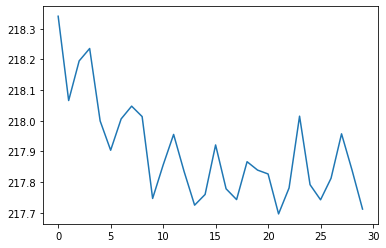

In [36]:
plt.plot(losses['test_loss'])
plt.plot(losses['test_loss'])

In [37]:
french_names = []
with open(NAMES_DIR / "french_names_no_accent.txt", "r") as f:
    for word in f:
        french_names.append(clean_word(word))
wiki_vae = AttentionVae.load("wiki_model")

split = 0.9
idx = int(len(french_names) * split)
np.random.seed(137)
np.random.shuffle(french_names)
train_french_names = french_names[:idx]
val_french_names = french_names[idx:]

raw_train_french_names = " ".join(train_french_names)
raw_val_french_names = " ".join(val_french_names)

train_dataset = CharDataset(raw_train_french_names, maxlen, chars=chars)
val_dataset = CharDataset(raw_val_french_names, maxlen, chars=chars)

idx=298
x, y, word = train_dataset[idx]
print("x: ",decode_word(x.numpy(), wiki_vae.itos))
print("y: ",decode_word(y.numpy(), wiki_vae.itos))
print("word :", decode_word(word.numpy(), wiki_vae.itos))

frozen_list = []
for par in wiki_vae.named_parameters():
    if "encoder" in par[0]:
        frozen_list.append(par[0])

frozen_wiki_vae = AttentionVae.load("wiki_model")
chars = list(wiki_vae.stoi.keys())
maxlen = wiki_vae.config.block_size

tconf = TrainerConfig(
    max_epochs=20,
    batch_size=128,
    learning_rate=6e-4,
    lr_decay=True,
    warmup_tokens=128 * 20,
    final_tokens=2 * len(train_dataset) * maxlen,
    num_workers=4,
    sample_freq=10000,
    freeze_layers=tuple(frozen_list)
)
trainer = Trainer(frozen_wiki_vae, train_dataset, val_dataset, tconf,log_nearest_words=True)
losses = trainer.train()

data has 34421 characters, 47 unique.
data has 3750 characters, 47 unique.
x:  genest
y:  genest
word : genest


epoch 1) iter 0: train_loss 221.1278687, lr = 5.999997e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: stales                    	 closes match: stanley 
Sample: new                       	 closes match: heliciane 
Sample: nateles                   	 closes match: naelie 
Sample: nite                      	 closes match: eugenie 


epoch 1) iter 4: train_loss 220.4481659, lr = 5.999080e-04:   1%|▏         | 4/269 [00:02<07:57,  1.80s/it]

Sample: storiping                 	 closes match: osip 


epoch 1) iter 268: train_loss 218.1376190, lr = 3.006754e-04: 100%|██████████| 269/269 [00:15<00:00, 17.89it/s]


Test loss: 218.23381703694662


epoch 2) iter 0: train_loss 217.6893616, lr = 2.989193e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zenodito                  	 closes match: zeno 
Sample: zil                       	 closes match: azilis 
Sample: mondren                   	 closes match: rene 
Sample: lea                       	 closes match: lea 


epoch 2) iter 4: train_loss 217.5057373, lr = 2.918956e-04:   1%|▏         | 4/269 [00:02<07:38,  1.73s/it]

Sample: aryno                     	 closes match: arno 


epoch 2) iter 268: train_loss 217.5757751, lr = 6.000000e-05: 100%|██████████| 269/269 [00:14<00:00, 18.00it/s]


Test loss: 218.09268747965496


epoch 3) iter 0: train_loss 217.9172211, lr = 6.000000e-05:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: anginaie                  	 closes match: gina 
Sample: namere                    	 closes match: ame 
Sample: zlisanie                  	 closes match: lisa 
Sample: ana                       	 closes match: ana 


epoch 3) iter 4: train_loss 218.3519287, lr = 6.000000e-05:   1%|▏         | 4/269 [00:02<08:03,  1.82s/it]

Sample: naudiline                 	 closes match: naud 


epoch 3) iter 268: train_loss 219.2994690, lr = 3.006754e-04: 100%|██████████| 269/269 [00:15<00:00, 17.84it/s]


Test loss: 218.0783198038737


epoch 4) iter 0: train_loss 217.7574158, lr = 3.024316e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zelisen                   	 closes match: elis 
Sample: redna                     	 closes match: ed 
Sample: berna                     	 closes match: bernat 
Sample: alyste                    	 closes match: alyse 


epoch 4) iter 4: train_loss 218.1048431, lr = 3.094547e-04:   1%|▏         | 4/269 [00:02<07:06,  1.61s/it]

Sample: rtue                      	 closes match: roberte 


epoch 4) iter 268: train_loss 217.8429260, lr = 5.999970e-04: 100%|██████████| 269/269 [00:14<00:00, 18.15it/s]


Test loss: 218.2106155395508


epoch 5) iter 0: train_loss 218.2715302, lr = 5.999839e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: igneme                    	 closes match: edme 
Sample: aguitte                   	 closes match: gui 
Sample: enae                      	 closes match: gwenael 
Sample: reanie                    	 closes match: rejane 


epoch 5) iter 4: train_loss 218.2711334, lr = 5.998289e-04:   1%|▏         | 4/269 [00:02<07:25,  1.68s/it]

Sample: nedy                      	 closes match: ed 


epoch 5) iter 268: train_loss 217.0904236, lr = 2.979737e-04: 100%|██████████| 269/269 [00:14<00:00, 18.09it/s]


Test loss: 218.0564931233724


epoch 6) iter 0: train_loss 217.6972961, lr = 2.962176e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zenrud                    	 closes match: zeno 
Sample: gtweodo                   	 closes match: odon 
Sample: netta                     	 closes match: simonetta 
Sample: rocane                    	 closes match: roxane 


epoch 6) iter 4: train_loss 217.8818054, lr = 2.891952e-04:   1%|▏         | 4/269 [00:02<06:28,  1.47s/it]

Sample: melio                     	 closes match: elio 


epoch 6) iter 268: train_loss 217.6049194, lr = 6.000000e-05: 100%|██████████| 269/269 [00:14<00:00, 18.45it/s]


Test loss: 217.85466715494792


epoch 7) iter 0: train_loss 218.1413574, lr = 6.000000e-05:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: nael                      	 closes match: ganaelle 
Sample: maryla                    	 closes match: mara 
Sample: melc                      	 closes match: melchisedech 
Sample: nendrie                   	 closes match: cendrine 


epoch 7) iter 4: train_loss 217.9858704, lr = 6.000000e-05:   1%|▏         | 4/269 [00:02<07:24,  1.68s/it]

Sample: geonz                     	 closes match: geronimo 


epoch 7) iter 268: train_loss 217.9793243, lr = 3.033772e-04: 100%|██████████| 269/269 [00:14<00:00, 18.05it/s]


Test loss: 217.98746795654296


epoch 8) iter 0: train_loss 217.6753845, lr = 3.051332e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: ange                      	 closes match: ange 
Sample: kerone                    	 closes match: geronce 
Sample: neve                      	 closes match: anaeve 
Sample: neeino                    	 closes match: nelio 


epoch 8) iter 4: train_loss 217.8954468, lr = 3.121547e-04:   1%|▏         | 4/269 [00:02<07:24,  1.68s/it]

Sample: ketreg                    	 closes match: rieg 


epoch 8) iter 268: train_loss 217.8167877, lr = 5.999726e-04: 100%|██████████| 269/269 [00:14<00:00, 18.09it/s]


Test loss: 217.99034423828124


epoch 9) iter 0: train_loss 217.8330383, lr = 5.999438e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zeaind                    	 closes match: zenaide 
Sample: anaide                    	 closes match: ana 
Sample: nerele                    	 closes match: neree 
Sample: kerva                     	 closes match: klervia 


epoch 9) iter 4: train_loss 217.5619507, lr = 5.997255e-04:   1%|▏         | 4/269 [00:02<06:42,  1.52s/it]

Sample: zeenad                    	 closes match: naud 


epoch 9) iter 268: train_loss 217.7242279, lr = 2.952721e-04: 100%|██████████| 269/269 [00:14<00:00, 18.38it/s]


Test loss: 217.85602874755858


epoch 10) iter 0: train_loss 217.9009094, lr = 2.935162e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: rechil                    	 closes match: hild 
Sample: zeamelia                  	 closes match: ame 
Sample: beran                     	 closes match: beranger 
Sample: neld                      	 closes match: renelde 


epoch 10) iter 4: train_loss 217.7371674, lr = 2.864956e-04:   1%|▏         | 4/269 [00:02<07:15,  1.64s/it]

Sample: yanise                    	 closes match: yanis 


epoch 10) iter 268: train_loss 216.8384857, lr = 6.000000e-05: 100%|██████████| 269/269 [00:14<00:00, 18.11it/s]


Test loss: 217.91805419921874


epoch 11) iter 0: train_loss 218.0385284, lr = 6.000000e-05:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zennian                   	 closes match: ian 
Sample: gwesla                    	 closes match: geslain 
Sample: engeslard                 	 closes match: angela 
Sample: azia                      	 closes match: aziza 


epoch 11) iter 4: train_loss 217.1583405, lr = 6.000000e-05:   1%|▏         | 4/269 [00:02<07:30,  1.70s/it]

Sample: audren                    	 closes match: audren 


epoch 11) iter 268: train_loss 216.9248962, lr = 3.060786e-04: 100%|██████████| 269/269 [00:14<00:00, 18.08it/s]


Test loss: 217.90989481608074


epoch 12) iter 0: train_loss 217.5589905, lr = 3.078343e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: anissia                   	 closes match: anissa 
Sample: nerene                    	 closes match: neree 
Sample: nerino                    	 closes match: ermin 
Sample: neettan                   	 closes match: nectan 


epoch 12) iter 4: train_loss 217.2676697, lr = 3.148538e-04:   1%|▏         | 4/269 [00:02<06:42,  1.52s/it]

Sample: zenobrien                 	 closes match: zeno 


epoch 12) iter 268: train_loss 217.6563873, lr = 5.999240e-04: 100%|██████████| 269/269 [00:14<00:00, 18.36it/s]


Test loss: 217.9332733154297


epoch 13) iter 0: train_loss 217.3386078, lr = 5.998793e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zen                       	 closes match: zenodore 
Sample: stephan                   	 closes match: stephan 
Sample: zena                      	 closes match: zenaide 
Sample: zesphaslee                	 closes match: lee 


epoch 13) iter 4: train_loss 217.7487640, lr = 5.995978e-04:   1%|▏         | 4/269 [00:02<08:36,  1.95s/it]

Sample: sternancha                	 closes match: erna 


epoch 13) iter 268: train_loss 217.9466095, lr = 2.925708e-04: 100%|██████████| 269/269 [00:15<00:00, 17.62it/s]


Test loss: 217.9802485148112


epoch 14) iter 0: train_loss 216.9792175, lr = 2.908153e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zechegue                  	 closes match: zachee 
Sample: nathonea                  	 closes match: anthone 
Sample: eodo                      	 closes match: theodosie 
Sample: naaline                   	 closes match: ali 


epoch 14) iter 4: train_loss 217.2705383, lr = 2.837971e-04:   1%|▏         | 4/269 [00:02<06:55,  1.57s/it]

Sample: nedoa                     	 closes match: ed 


epoch 14) iter 268: train_loss 216.4448547, lr = 6.000000e-05: 100%|██████████| 269/269 [00:14<00:00, 18.31it/s]


Test loss: 217.83257548014322


epoch 15) iter 0: train_loss 217.0905609, lr = 6.000000e-05:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: annelle                   	 closes match: annaelle 
Sample: zenona                    	 closes match: zenon 
Sample: androu                    	 closes match: nandou 
Sample: angeline                  	 closes match: angeline 


epoch 15) iter 4: train_loss 217.7087708, lr = 6.000000e-05:   1%|▏         | 4/269 [00:02<06:57,  1.58s/it]

Sample: zen                       	 closes match: zenodore 


epoch 15) iter 268: train_loss 217.7761993, lr = 3.087796e-04: 100%|██████████| 269/269 [00:14<00:00, 18.26it/s]


Test loss: 217.88069712320964


epoch 16) iter 0: train_loss 217.7259979, lr = 3.105348e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: xavin                     	 closes match: alvin 
Sample: zena                      	 closes match: zenaide 
Sample: renatine                  	 closes match: renaldine 
Sample: nedette                   	 closes match: ed 


epoch 16) iter 4: train_loss 217.3831787, lr = 3.175516e-04:   1%|▏         | 4/269 [00:02<06:55,  1.57s/it]

Sample: anestin                   	 closes match: estin 


epoch 16) iter 268: train_loss 217.1244965, lr = 5.998510e-04: 100%|██████████| 269/269 [00:14<00:00, 18.31it/s]


Test loss: 218.05355122884114


epoch 17) iter 0: train_loss 218.0071716, lr = 5.997905e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zemarda                   	 closes match: mara 
Sample: zephoriend                	 closes match: zephyrin 
Sample: zisaclia                  	 closes match: lia 
Sample: staniane                  	 closes match: tania 


epoch 17) iter 4: train_loss 217.1252136, lr = 5.994459e-04:   1%|▏         | 4/269 [00:02<07:32,  1.71s/it]

Sample: zenope                    	 closes match: zeno 


epoch 17) iter 268: train_loss 217.1199951, lr = 2.898702e-04: 100%|██████████| 269/269 [00:14<00:00, 18.08it/s]


Test loss: 217.93982493082683


epoch 18) iter 0: train_loss 218.1972809, lr = 2.881152e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: kelia                     	 closes match: kelian 
Sample: artaudine                 	 closes match: tudine 
Sample: nevoria                   	 closes match: oria 
Sample: zephine                   	 closes match: zephirine 


epoch 18) iter 4: train_loss 217.4493866, lr = 2.811000e-04:   1%|▏         | 4/269 [00:02<06:55,  1.57s/it]

Sample: nessy                     	 closes match: kessy 


epoch 18) iter 268: train_loss 217.1629639, lr = 6.000000e-05: 100%|██████████| 269/269 [00:14<00:00, 18.27it/s]


Test loss: 217.74228261311848


epoch 19) iter 0: train_loss 218.2636414, lr = 6.000000e-05:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: clararie                  	 closes match: clar 
Sample: nessanin                  	 closes match: nin 
Sample: renael                    	 closes match: enael 
Sample: reply                     	 closes match: lys 


epoch 19) iter 4: train_loss 216.7178345, lr = 6.000000e-05:   1%|▏         | 4/269 [00:02<07:31,  1.70s/it]

Sample: zephallee                 	 closes match: lee 


epoch 19) iter 268: train_loss 216.8243103, lr = 3.114798e-04: 100%|██████████| 269/269 [00:14<00:00, 18.06it/s]


Test loss: 218.00097045898437


epoch 20) iter 0: train_loss 217.2340393, lr = 3.132345e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: theopha                   	 closes match: theo 
Sample: neston                    	 closes match: nelson 
Sample: refimit                   	 closes match: remi 
Sample: georgane                  	 closes match: georgiane 


epoch 20) iter 4: train_loss 217.8718109, lr = 3.202480e-04:   1%|▏         | 4/269 [00:02<06:20,  1.44s/it]

Sample: nelis                     	 closes match: lis 


epoch 20) iter 268: train_loss 218.6749420, lr = 5.997537e-04: 100%|██████████| 269/269 [00:14<00:00, 18.51it/s]


Test loss: 217.95996602376303


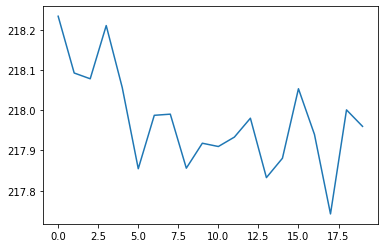

In [38]:
plt.plot(losses['test_loss'])

In [29]:
losses = []
loader = DataLoader(
            val_dataset,
            shuffle=False,
            pin_memory=True,
            batch_size=128
        )
for x, y, word in loader:
    with torch.no_grad():
        x = x.to(frozen_wiki_vae.device)
        y = y.to(trainer.device)
        word = word.to(frozen_wiki_vae.device)
        logits, loss_dict = frozen_wiki_vae.model(x, y, word, training=True)

        losses.append(loss_dict["loss"])
        
    

ModuleAttributeError: 'AttentionVae' object has no attribute 'device'

In [ ]:
french_vae = AttentionVae.load("french_model")
tconf = TrainerConfig(
    max_epochs=10,
    batch_size=128,
    learning_rate=6e-4,
    lr_decay=True,
    warmup_tokens=128 * 20,
    final_tokens=2 * len(train_dataset) * maxlen,
    num_workers=4,
)
trainer = Trainer(french_vae, train_dataset, None, tconf)
losses = trainer.train()

In [15]:
from fuzzywuzzy import process

In [28]:
train_dataset.word_list

In [29]:
print(french_names)

match = process.extract("list", french_names, limit=2)

In [23]:
match

In [84]:
config = GPTConfig(train_dataset.vocab_size, maxlen, n_layer=2, n_head=4, n_embd=64)
plain_vae = AttentionVae(config)
tconf = TrainerConfig(
    max_epochs=10,
    batch_size=128,
    learning_rate=6e-4,
    lr_decay=True,
    warmup_tokens=128 * 20,
    final_tokens=2 * len(train_dataset) * maxlen,
    num_workers=4,
)
trainer = Trainer(plain_vae, train_dataset, None, tconf)
losses = trainer.train()

number of parameters: 851904


  0%|          | 0/299 [00:00<?, ?it/s]/home/simon/code/namegen/avae/src/avae/trainer.py:101: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  self.model.parameters(), self.config.grad_norm_clip
epoch 1) iter 0: train_loss 567.6885986, lr = 5.999998e-04:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample:  éà                         	 Closest match is aanor
Sample: i-ànwcg                     	 Closest match is inigo


Sample:  àöoöcqüàöà à               	 Closest match is aliocha
Sample:                             	 Closest match is aanor


epoch 1) iter 3: train_loss 455.8023376, lr = 5.999564e-04:   1%|          | 3/299 [00:01<05:53,  1.20s/it]

Sample: 'iqöi                       	 Closest match is aaricia


epoch 1) iter 298: train_loss 224.3321991, lr = 3.006089e-04: 100%|██████████| 299/299 [00:17<00:00, 17.15it/s]
epoch 2) iter 0: train_loss 225.4807281, lr = 2.990257e-04:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: ale                         	 Closest match is aleaume
Sample: paleoia                     	 Closest match is alexia


Sample: orito                       	 Closest match is aristote
Sample:                             	 Closest match is aanor


epoch 2) iter 3: train_loss 224.8954773, lr = 2.942763e-04:   1%|          | 3/299 [00:02<08:04,  1.64s/it]

Sample: erinno                      	 Closest match is zeferino


epoch 2) iter 298: train_loss 226.9024658, lr = 6.000000e-05: 100%|██████████| 299/299 [00:17<00:00, 16.63it/s]
epoch 3) iter 0: train_loss 223.4640198, lr = 6.000000e-05:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: ginili                      	 Closest match is quintilien
Sample: guente                      	 Closest match is guenaelle
Sample: lbarero                     	 Closest match is alberto
Sample: maninta                     	 Closest match is anita


epoch 3) iter 3: train_loss 223.3650513, lr = 6.000000e-05:   1%|          | 3/299 [00:02<08:39,  1.75s/it]

Sample: grone                       	 Closest match is geronce


epoch 3) iter 298: train_loss 221.9121094, lr = 3.006089e-04: 100%|██████████| 299/299 [00:18<00:00, 16.48it/s]
epoch 4) iter 0: train_loss 223.3574066, lr = 3.021922e-04:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: sasidrc                     	 Closest match is said
Sample: lacirtino                   	 Closest match is tino
Sample: shrieldrnde                 	 Closest match is hildebrande
Sample: cagurtin                    	 Closest match is augustin


epoch 4) iter 3: train_loss 222.5893860, lr = 3.069414e-04:   1%|          | 3/299 [00:03<10:53,  2.21s/it]

Sample: stlo                        	 Closest match is aristote


epoch 4) iter 298: train_loss 223.5995789, lr = 5.999975e-04: 100%|██████████| 299/299 [00:18<00:00, 15.81it/s]
epoch 5) iter 0: train_loss 223.7321777, lr = 5.999869e-04:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: losta                       	 Closest match is lossa
Sample: cymie                       	 Closest match is cyrielle
Sample: jelloeniinon                	 Closest match is ellen
Sample: adodener                    	 Closest match is ode


epoch 5) iter 3: train_loss 223.0262756, lr = 5.999050e-04:   1%|          | 3/299 [00:03<11:24,  2.31s/it]

Sample: jora                        	 Closest match is joran


epoch 5) iter 298: train_loss 223.2532806, lr = 2.981732e-04: 100%|██████████| 299/299 [00:19<00:00, 15.68it/s]
epoch 6) iter 0: train_loss 223.5447083, lr = 2.965900e-04:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: matau                       	 Closest match is amata
Sample: esian                       	 Closest match is elian
Sample: aleunse                     	 Closest match is arlene
Sample: gicia                       	 Closest match is gilia


epoch 6) iter 3: train_loss 222.6663055, lr = 2.918411e-04:   1%|          | 3/299 [00:02<09:46,  1.98s/it]

Sample: edrma                       	 Closest match is edma


epoch 6) iter 298: train_loss 217.3303680, lr = 6.000000e-05: 100%|██████████| 299/299 [00:18<00:00, 16.16it/s]
epoch 7) iter 0: train_loss 222.6403198, lr = 6.000000e-05:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: ansare                      	 Closest match is anskar
Sample: emand                       	 Closest match is emiland
Sample: sialle                      	 Closest match is austregisille
Sample: macirenne                   	 Closest match is irene


epoch 7) iter 3: train_loss 223.4590149, lr = 6.000000e-05:   1%|          | 3/299 [00:02<09:40,  1.96s/it]

Sample: elisiane                    	 Closest match is eliane


epoch 7) iter 298: train_loss 223.3740845, lr = 3.030447e-04: 100%|██████████| 299/299 [00:18<00:00, 16.20it/s]
epoch 8) iter 0: train_loss 222.2140503, lr = 3.046278e-04:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: cleerine                    	 Closest match is cedrine
Sample: mailinnite                  	 Closest match is miline
Sample: guerttia                    	 Closest match is tia
Sample: saioldine                   	 Closest match is soline


epoch 8) iter 3: train_loss 222.3113251, lr = 3.093762e-04:   1%|          | 3/299 [00:02<09:20,  1.89s/it]

Sample: thann                       	 Closest match is samthann


epoch 8) iter 298: train_loss 220.3882141, lr = 5.999778e-04: 100%|██████████| 299/299 [00:18<00:00, 16.23it/s]
epoch 9) iter 0: train_loss 221.4678802, lr = 5.999543e-04:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: gennediere                  	 Closest match is genevieve
Sample: lera                        	 Closest match is wallerand
Sample: legoni                      	 Closest match is leonie
Sample: londu                       	 Closest match is londa


epoch 9) iter 3: train_loss 223.1580200, lr = 5.998338e-04:   1%|          | 3/299 [00:03<10:56,  2.22s/it]

Sample: corn                        	 Closest match is cornaline


epoch 9) iter 298: train_loss 224.4233398, lr = 2.957375e-04: 100%|██████████| 299/299 [00:18<00:00, 15.83it/s]
epoch 10) iter 0: train_loss 221.9709015, lr = 2.941545e-04:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: natle                       	 Closest match is anatole
Sample: noass                       	 Closest match is thomassia
Sample: maudian                     	 Closest match is ian
Sample: graidole                    	 Closest match is agricole


epoch 10) iter 3: train_loss 223.1546631, lr = 2.894066e-04:   1%|          | 3/299 [00:02<09:06,  1.85s/it]

Sample: eliana                      	 Closest match is eliana


epoch 10) iter 298: train_loss 220.4730225, lr = 6.000000e-05: 100%|██████████| 299/299 [00:18<00:00, 16.31it/s]


In [82]:
train_dataset.block_size

26

In [ ]:
print("plain")
print()
initial_context = "sam"
outputs = generate_samples(initial_context, plain_vae)
for out in outputs:
    print(out)
print()

print("wiki")
print()
initial_context = "sam"
outputs = generate_samples(initial_context, wiki_vae)
for out in outputs:
    print(out)
print()

print("french")
print()
initial_context = "samanth"
outputs = generate_samples(initial_context, french_vae)
for out in outputs:
    print(out)
print()

In [96]:
process.extract("samantha", french_names)

[('samantha', 100), ('sam', 90), ('amata', 77), ('thao', 77), ('thea', 77)]